Loading expression data...
Loading promoter oxidation data...
Loading significant bins data...
Expression data sample:
   Unnamed: 0                Gene  Expression_level           Sample  \
0           0  ENSMUSG00000000001         15.613475  01_Ctrl_morning   
1           1  ENSMUSG00000000003          0.000000  01_Ctrl_morning   
2           2  ENSMUSG00000000028          0.775004  01_Ctrl_morning   
3           3  ENSMUSG00000000031          0.099366  01_Ctrl_morning   
4           4  ENSMUSG00000000037          0.403567  01_Ctrl_morning   

          Group  
0  Ctrl_morning  
1  Ctrl_morning  
2  Ctrl_morning  
3  Ctrl_morning  
4  Ctrl_morning  

Promoter oxidation data sample:
                   id                      sample                gene strand  \
0  ENSMUSG00000000001  Sample_01_Ctrl_morning_S1_  ENSMUSG00000000001      -   
1  ENSMUSG00000000028  Sample_01_Ctrl_morning_S1_  ENSMUSG00000000028      -   
2  ENSMUSG00000000031  Sample_01_Ctrl_morning_S1_  ENSMUSG000000000

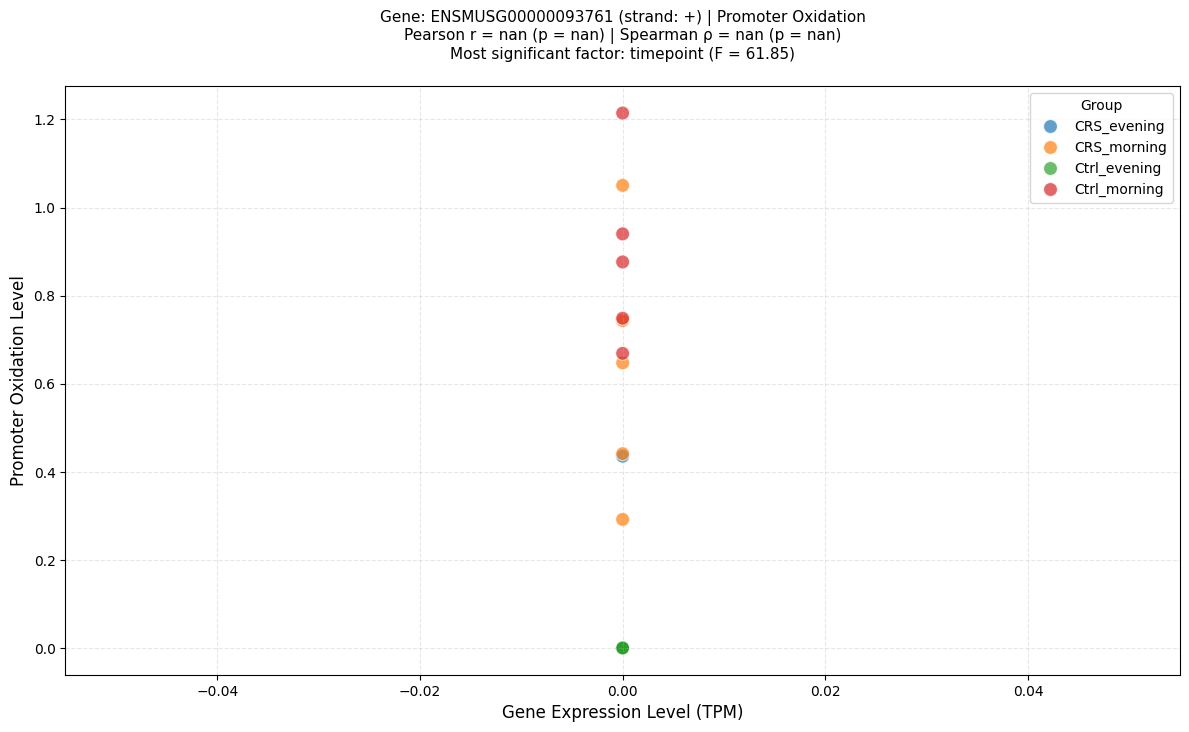

Plot saved to ../images/significant_gene_correlation_plots/ENSMUSG00000093761_+_promoter_correlations.png
Correlations - Pearson: nan (p=nan), Spearman: nan (p=nan)
Processing gene: ENSMUSG00000143378 (strand: +)
No direct match found for ENSMUSG00000143378, checking for partial matches...
Processing gene: ENSMUSG00000030793 (strand: +)


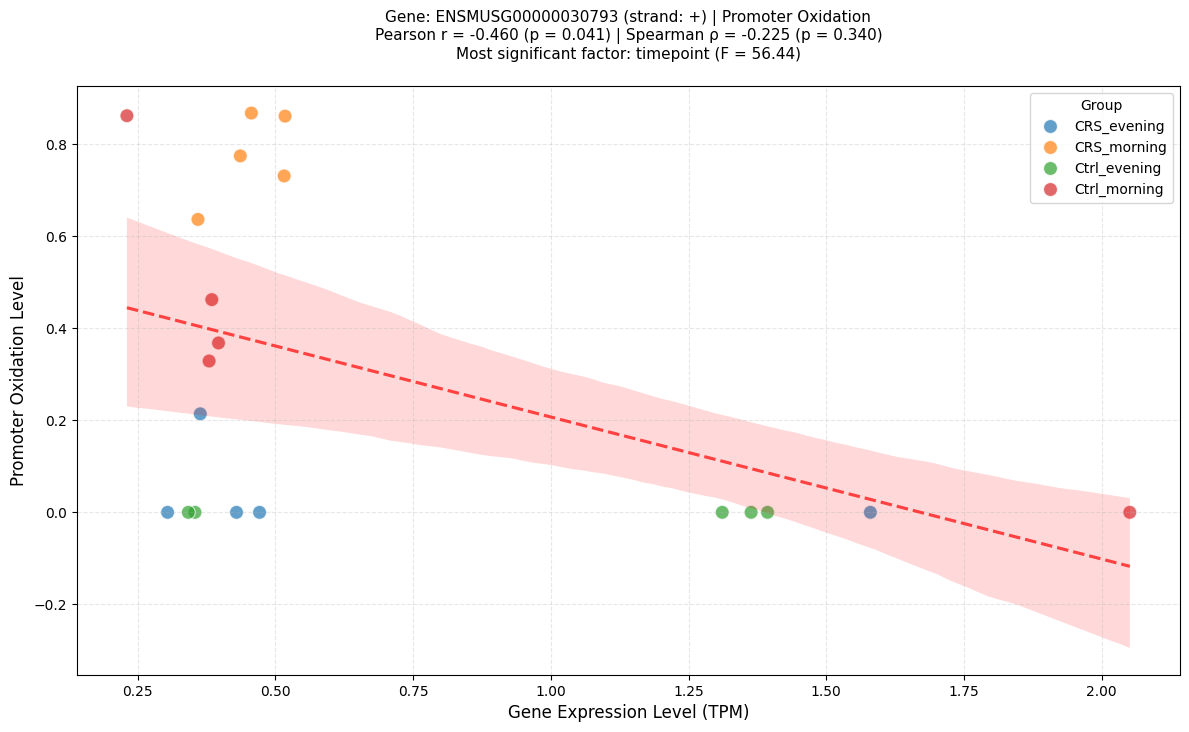

Plot saved to ../images/significant_gene_correlation_plots/ENSMUSG00000030793_+_promoter_correlations.png
Correlations - Pearson: -0.460 (p=0.041), Spearman: -0.225 (p=0.340)

Summary saved to ../images/significant_gene_correlation_plots/promoter_correlation_summary.csv

=== PROMOTER CORRELATION ANALYSIS SUMMARY ===
Total significant genes analyzed: 2
Mean Pearson correlation: -0.460
Mean Spearman correlation: -0.225
Significant Pearson correlations (p < 0.05): 1/2 (50.0%)
Significant Spearman correlations (p < 0.05): 0/2 (0.0%)

Genes with substantial difference between Pearson and Spearman (|Δr| > 0.2):
           gene_id strand  pearson_r  spearman_r most_significant_factor
ENSMUSG00000030793      +  -0.459719   -0.224941               timepoint

Top 5 strongest Pearson correlations:
           gene_id strand  pearson_r  pearson_p most_significant_factor
ENSMUSG00000030793      +  -0.459719   0.041416               timepoint
ENSMUSG00000093761      +        NaN        NaN           

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from pathlib import Path
import numpy as np
import warnings
from scipy.stats import pearsonr, spearmanr
# Suppress warnings
warnings.filterwarnings('ignore')

# This is for the promoter data as they already have corresponding genes

# File paths
EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
PROMOTER_OXID = "../data_normalized/promoters_Normalized.csv"
SIGNIFICANT_BINS = "../data_anova/promoters/anova_all_significant_bins.csv"

# Create output directory for plots
output_dir = Path("../images/significant_gene_correlation_plots")
output_dir.mkdir(exist_ok=True)

# Function to extract group from sample name
def extract_group_expr(sample):
    # Expected format: '20_CRS_evening'
    parts = sample.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return "Unknown"

def extract_group_oxid(sample):
    # Expected format: 'Sample_14_CRS_evening_S14_'
    parts = sample.split('_')
    if len(parts) >= 5:
        return f"{parts[2]}_{parts[3]}"
    return "Unknown"

def extract_gene_and_strand(bin_id):
    """Extract gene ID and strand from bin_id (e.g., 'ENSMUSG00000104528+' -> ('ENSMUSG00000104528', '+'))"""
    if bin_id.endswith('+') or bin_id.endswith('-'):
        return bin_id[:-1], bin_id[-1]
    return bin_id, None

# Function to calculate both correlations with p-values
def calculate_correlations(x, y):
    """Calculate both Pearson and Spearman correlations with p-values"""
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) < 3:  # Need at least 3 points for meaningful correlation
        return None, None, None, None
    
    # Calculate Pearson correlation
    pearson_r, pearson_p = pearsonr(x_clean, y_clean)
    
    # Calculate Spearman correlation
    spearman_r, spearman_p = spearmanr(x_clean, y_clean)
    
    return pearson_r, pearson_p, spearman_r, spearman_p

# Load data
def load_data():
    print("Loading expression data...")
    expr_df = pd.read_csv(EXPR_PATH)
    
    print("Loading promoter oxidation data...")
    promoter_df = pd.read_csv(PROMOTER_OXID)
    
    print("Loading significant bins data...")
    sig_bins_df = pd.read_csv(SIGNIFICANT_BINS)
    
    # Process expression data
    # Add group column based on Sample column
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    print("Expression data sample:")
    print(expr_df.head(5))
    
    # Process oxidation data
    # Add group column based on sample name
    promoter_df['Group'] = promoter_df['sample'].apply(extract_group_oxid)
    print("\nPromoter oxidation data sample:")
    print(promoter_df.head(5))
    
    print("\nSignificant bins data:")
    print(sig_bins_df.head())
    
    return expr_df, promoter_df, sig_bins_df

# Load gene information from significant bins
def load_significant_genes(sig_bins_df):
    significant_genes = []
    
    for _, row in sig_bins_df.iterrows():
        bin_id = row['bin_id']
        gene_id, strand = extract_gene_and_strand(bin_id)
        
        significant_genes.append({
            'gene_id': gene_id,
            'strand': strand,
            'bin_id': bin_id,
            'most_significant_factor': row['most_significant_factor'],
            'max_f_value': row['max_f_value'],
            'significant_factors': row['significant_factors']
        })
        
        print(f"Found significant gene: {gene_id} (strand: {strand})")
    
    return significant_genes

# Function to create scatter plot for a gene with both correlations
def plot_gene_correlation(gene_info, expr_df, promoter_df):
    gene_id = gene_info['gene_id']
    strand = gene_info['strand']
    bin_id = gene_info['bin_id']
    
    print(f"Processing gene: {gene_id} (strand: {strand})")
    
    # Find expression data for this gene
    # Note: You may need to adjust this depending on how gene IDs are stored in your expression data
    # The expression data might use a different gene identifier format
    gene_expr = expr_df[expr_df['Gene'] == gene_id]
    
    if gene_expr.empty:
        # Try alternative matching - sometimes gene IDs might be in different formats
        print(f"No direct match found for {gene_id}, checking for partial matches...")
        # You might need to implement fuzzy matching or use gene name instead of ID
        return None
    
    # Find corresponding oxidation data entries
    # Match by gene ID and strand (using separate columns)
    gene_oxid = promoter_df[
        (promoter_df['id'] == gene_id) & 
        (promoter_df['strand'] == strand)
    ]
    
    if gene_oxid.empty:
        print(f"No oxidation data found for gene {gene_id} with strand {strand}")
        return None
    
    # Prepare data for plotting by matching samples
    plot_data = []
    
    for group in ['CRS_evening', 'CRS_morning', 'Ctrl_evening', 'Ctrl_morning']:
        # Get expression values for this group
        group_expr = gene_expr[gene_expr['Group'] == group]
        
        # Get oxidation values for this group
        group_oxid = gene_oxid[gene_oxid['Group'] == group]
        
        # Combine data from both sources
        min_samples = min(len(group_expr), len(group_oxid))
        
        for i in range(min_samples):
            try:
                expr_value = group_expr.iloc[i]['Expression_level']
                # Adjust column name as needed - check your promoter data structure
                oxid_value = group_oxid.iloc[i]['median_normalized_damage']  # or whatever the column name is
                
                plot_data.append({
                    'Expression': expr_value,
                    'Oxidation': oxid_value,
                    'Group': group
                })
            except (IndexError, KeyError) as e:
                print(f"Error accessing data for {group}, sample {i}: {e}")
                continue
    
    # Create DataFrame from collected data
    if not plot_data:
        print(f"No matching data points found for gene {gene_id}")
        return None
    
    plot_df = pd.DataFrame(plot_data)
    
    # Calculate both correlations
    expr_values = plot_df['Expression'].values
    oxid_values = plot_df['Oxidation'].values
    
    pearson_r, pearson_p, spearman_r, spearman_p = calculate_correlations(expr_values, oxid_values)
    
    if pearson_r is None:
        print(f"Insufficient data points for correlation analysis for gene {gene_id}")
        return None
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot with color-coded groups
    sns.scatterplot(
        data=plot_df, 
        x='Expression', 
        y='Oxidation', 
        hue='Group', 
        palette='tab10',
        s=100,
        alpha=0.7
    )
    
    # Add trend line for all data
    if len(plot_df) > 1:
        sns.regplot(
            data=plot_df, 
            x='Expression', 
            y='Oxidation', 
            scatter=False, 
            line_kws={"color": "red", "linestyle": "--", "alpha": 0.7}
        )
    
    # Create title with both correlations and additional information
    title = f'Gene: {gene_id} (strand: {strand}) | Promoter Oxidation\n'
    title += f'Pearson r = {pearson_r:.3f} (p = {pearson_p:.3f}) | '
    title += f'Spearman ρ = {spearman_r:.3f} (p = {spearman_p:.3f})\n'
    title += f'Most significant factor: {gene_info["most_significant_factor"]} '
    title += f'(F = {gene_info["max_f_value"]:.2f})'
    
    plt.title(title, fontsize=11, pad=20)
    plt.xlabel('Gene Expression Level (TPM)', fontsize=12)
    plt.ylabel('Promoter Oxidation Level', fontsize=12)
    
    
    # Add legend
    plt.legend(title='Group', fontsize=10)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Adjust layout to prevent text cutoff
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    # Save plot
    output_path = output_dir / f"{gene_id}_{strand}_promoter_correlations.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {output_path}")
    print(f"Correlations - Pearson: {pearson_r:.3f} (p={pearson_p:.3f}), Spearman: {spearman_r:.3f} (p={spearman_p:.3f})")
    
    return {
        'gene_id': gene_id,
        'strand': strand,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'n_points': len(plot_df),
        'most_significant_factor': gene_info['most_significant_factor'],
        'max_f_value': gene_info['max_f_value']
    }

# Function to run analysis on all significant genes and create summary
def run_promoter_correlation_analysis():
    """Run correlation analysis on all significant promoter genes and create a summary table"""
    # Load data
    expr_df, promoter_df, sig_bins_df = load_data()
    significant_genes = load_significant_genes(sig_bins_df)
    
    # Store results
    results = []
    
    # Process each significant gene
    for gene_info in significant_genes:
        result = plot_gene_correlation(gene_info, expr_df, promoter_df)
        if result is not None:
            results.append(result)
    
    # Create summary DataFrame
    if results:
        summary_df = pd.DataFrame(results)
        
        # Save summary to CSV
        summary_path = output_dir / "promoter_correlation_summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\nSummary saved to {summary_path}")
        
        # Print summary statistics
        print("\n=== PROMOTER CORRELATION ANALYSIS SUMMARY ===")
        print(f"Total significant genes analyzed: {len(summary_df)}")
        print(f"Mean Pearson correlation: {summary_df['pearson_r'].mean():.3f}")
        print(f"Mean Spearman correlation: {summary_df['spearman_r'].mean():.3f}")
        
        # Count significant correlations
        sig_pearson = (summary_df['pearson_p'] < 0.05).sum()
        sig_spearman = (summary_df['spearman_p'] < 0.05).sum()
        
        print(f"Significant Pearson correlations (p < 0.05): {sig_pearson}/{len(summary_df)} ({sig_pearson/len(summary_df)*100:.1f}%)")
        print(f"Significant Spearman correlations (p < 0.05): {sig_spearman}/{len(summary_df)} ({sig_spearman/len(summary_df)*100:.1f}%)")
        
        # Show cases where correlations differ substantially
        diff_threshold = 0.2
        large_diff = abs(summary_df['pearson_r'] - summary_df['spearman_r']) > diff_threshold
        if large_diff.any():
            print(f"\nGenes with substantial difference between Pearson and Spearman (|Δr| > {diff_threshold}):")
            diff_genes = summary_df[large_diff][['gene_id', 'strand', 'pearson_r', 'spearman_r', 'most_significant_factor']]
            print(diff_genes.to_string(index=False))
        
        # Show strongest correlations
        print(f"\nTop 5 strongest Pearson correlations:")
        top_pearson = summary_df.nlargest(5, 'pearson_r')[['gene_id', 'strand', 'pearson_r', 'pearson_p', 'most_significant_factor']]
        print(top_pearson.to_string(index=False))
        
        print(f"\nTop 5 strongest Spearman correlations:")
        top_spearman = summary_df.nlargest(5, 'spearman_r')[['gene_id', 'strand', 'spearman_r', 'spearman_p', 'most_significant_factor']]
        print(top_spearman.to_string(index=False))
    
    return summary_df if results else None


summary = run_promoter_correlation_analysis()